<a href="https://colab.research.google.com/github/SHASHANK616/MLproject/blob/main/eventsManage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# events_df=pd.read_csv("/content/drive/MyDrive/MLAnujProject/events.csv")

Missing Values before cleaning:
 event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64
Duplicate Rows before cleaning: 401
Data Types after cleaning:
 event_time       datetime64[ns, UTC]
event_type                    object
product_id                     int64
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
dtype: object

--- Event Distributions ---


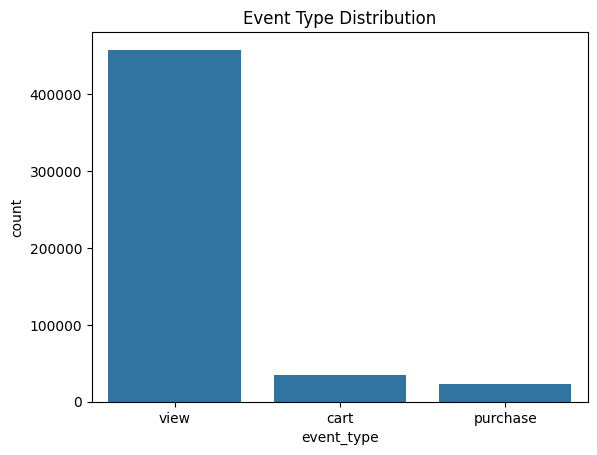


--- Event Over Time ---


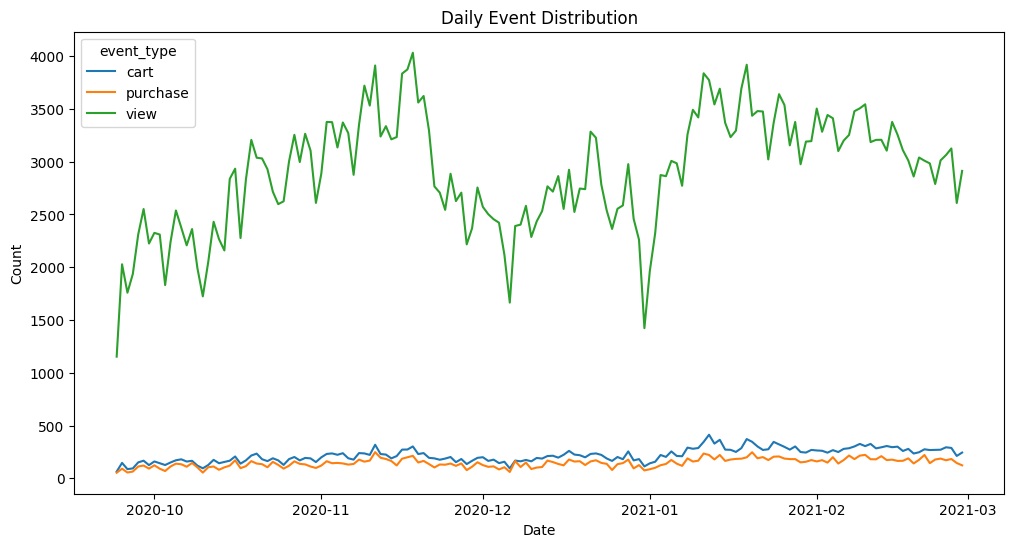


--- Brand Popularity ---


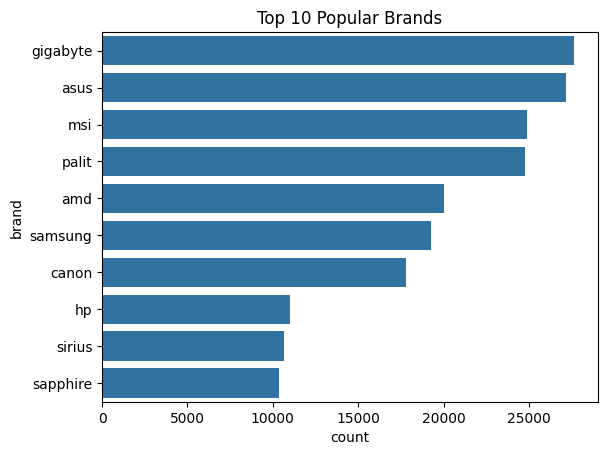


--- Category Popularity ---


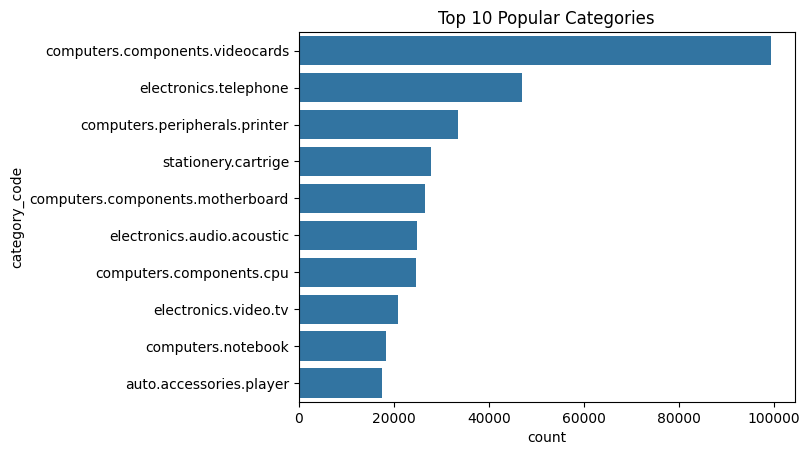

Churned Users Count: 10096

--- Feature Engineering ---

--- Modeling ---
Confusion Matrix:
 [[42477   527]
 [  166  1825]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99     43004
        True       0.78      0.92      0.84      1991

    accuracy                           0.98     44995
   macro avg       0.89      0.95      0.92     44995
weighted avg       0.99      0.98      0.99     44995


--- Model Interpretation ---


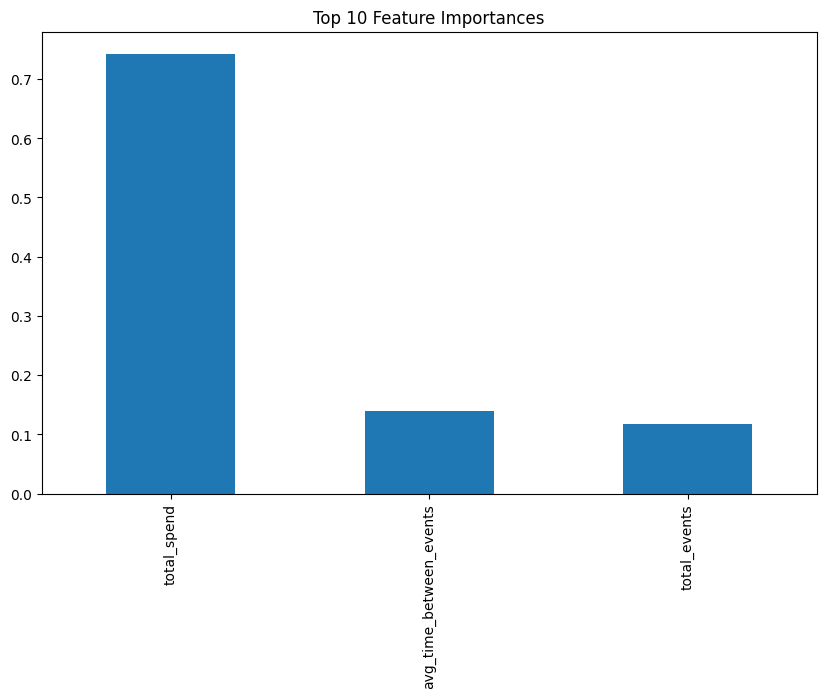


--- Recommendations ---
1. Target users with high activity but no purchases using personalized offers.
2. Identify users with long time gaps between sessions and send re-engagement campaigns.
3. Analyze popular brands and categories to optimize inventory and marketing strategies.


In [ ]:
# ----------------------------
# 1. Data Inspection & Preprocessing
# ----------------------------

def load_and_clean_data(filepath):
    data = pd.read_csv("/content/drive/MyDrive/MLAnujProject/events.csv")

    # Handle missing values
    print("Missing Values before cleaning:\n", data.isnull().sum())
    data = data.dropna()  # Drop rows with missing values

    # Handle duplicates
    print("Duplicate Rows before cleaning:", data.duplicated().sum())
    data = data.drop_duplicates()

    # Parse event_time and ensure correct data types
    data['event_time'] = pd.to_datetime(data['event_time'])

    # Data types verification
    print("Data Types after cleaning:\n", data.dtypes)
    return data

data = load_and_clean_data('events.csv')

# ----------------------------
# 2. Exploratory Data Analysis (EDA)
# ----------------------------

def exploratory_data_analysis(data):
    print("\n--- Event Distributions ---")
    sns.countplot(x='event_type', data=data, order=data['event_type'].value_counts().index)
    plt.title('Event Type Distribution')
    plt.show()

    print("\n--- Event Over Time ---")
    data['date'] = data['event_time'].dt.date
    daily_events = data.groupby(['date', 'event_type']).size().unstack(fill_value=0)
    daily_events.plot(kind='line', figsize=(12, 6))
    plt.title('Daily Event Distribution')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()

    print("\n--- Brand Popularity ---")
    sns.countplot(y='brand', data=data, order=data['brand'].value_counts().head(10).index)
    plt.title('Top 10 Popular Brands')
    plt.show()

    print("\n--- Category Popularity ---")
    sns.countplot(y='category_code', data=data, order=data['category_code'].value_counts().head(10).index)
    plt.title('Top 10 Popular Categories')
    plt.show()

exploratory_data_analysis(data)

# ----------------------------
# 3. Defining Churn
# ----------------------------

def define_churn(data):
    # Define churn as no purchase in the last 30 days
    data['is_purchase'] = data['event_type'] == 'purchase'
    churn_threshold = pd.Timestamp(data['event_time'].max()) - pd.Timedelta(days=30)
    user_last_purchase = data[data['is_purchase']].groupby('user_id')['event_time'].max()
    churned_users = user_last_purchase[user_last_purchase < churn_threshold].index
    data['is_churn'] = data['user_id'].isin(churned_users)
    print("Churned Users Count:", len(churned_users))
    return data

data = define_churn(data)

# ----------------------------
# 4. Feature Engineering
# ----------------------------

def feature_engineering(data):
    print("\n--- Feature Engineering ---")
    features = pd.DataFrame()

    # Example: Total events per user
    features['total_events'] = data.groupby('user_id').size()

    # Example: Total spend per user
    features['total_spend'] = data[data['event_type'] == 'purchase'].groupby('user_id')['price'].sum().fillna(0)

    # Example: Average time between events
    time_diffs = data.groupby('user_id')['event_time'].diff().dt.total_seconds()
    features['avg_time_between_events'] = time_diffs.groupby(data['user_id']).mean().fillna(0)

    # Churn label
    features['is_churn'] = features.index.isin(data[data['is_churn']]['user_id'])

    return features

features = feature_engineering(data)

# ----------------------------
# 5. Modeling
# ----------------------------

def train_model(features):
    print("\n--- Modeling ---")

    # Prepare data
    X = features.drop(columns=['is_churn'])
    y = features['is_churn']

    # Encoding categorical features if any
    le = LabelEncoder()
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = le.fit_transform(X[col])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model

model = train_model(features)

# ----------------------------
# 6. Interpretation & Explanation
# ----------------------------

def model_interpretation(model, features):
    print("\n--- Model Interpretation ---")

    feature_importances = pd.Series(model.feature_importances_, index=features.drop(columns=['is_churn']).columns)
    feature_importances.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6))
    plt.title('Top 10 Feature Importances')
    plt.show()

model_interpretation(model, features)

# ----------------------------
# 7. Recommendations & Conclusions
# ----------------------------

def recommendations():
    print("\n--- Recommendations ---")
    print("1. Target users with high activity but no purchases using personalized offers. This could include discounts, free trials, or exclusive product access.")
    print("2. Identify users with long time gaps between sessions and send re-engagement campaigns. Campaigns can include reminders, newsletters, or incentives for returning.")
    print("3. Analyze popular brands and categories to optimize inventory and marketing strategies. This helps in focusing on high-demand products and streamlining stock management.")
    print("4. Create segmented user retention strategies based on behavior. For example, categorize users into active, dormant, and at-risk groups, and tailor outreach accordingly.")
    print("5. Use churn prediction scores to prioritize users for intervention. Focus efforts on users most likely to churn within the next prediction window.")
    print("6. Continuously evaluate the impact of retention strategies through A/B testing and refine approaches based on data insights.")

recommendations()

